# Aggregate annotation for the generated sentences

In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="white")

In [2]:
!pip install openpyxl
data_dir = "../data/annotated_data_raw/gerpt2_generated_regard_w_annotations"
out_path = "../plots"
os.makedirs(out_path, exist_ok=True)

You should consider upgrading via the '/home/angelie/Documents/University/Thesis/bias-in-german-nlg/venv/bin/python -m pip install --upgrade pip' command.


In [3]:
annotations = pd.DataFrame()
annotator_names =  []
for i, annotation in enumerate(os.listdir(data_dir)):
    if annotation.endswith(".xlsx"):
        print(annotation)
        annotator = annotation.split('_')[-1].split('.')[0]
        annotator_names += [annotator]
        data = pd.read_excel(os.path.join(data_dir, annotation), index_col=0).iloc[:378]
        if i == 0:
            annotations['Text'] = data['Text']
        if 'Unsicher' in data.columns:
            annotations[f'Unsicher_{annotator}'] = data['Unsicher']
            print(annotator, ": #unsicher", sum(~data['Unsicher'].isna()))
            annotations[annotator] = data['Label'].fillna(98)
            annotations.loc[~annotations[f'Unsicher_{annotator}'].isna(), annotator] = 98
            annotations[annotator] = annotations[annotator].astype(int)

trigger_targets_annotator_4.xlsx
4 : #unsicher 1
trigger_targets_annotator_0.xlsx
0 : #unsicher 0
trigger_targets_annotator_3.xlsx
3 : #unsicher 10
trigger_targets_annotator_2.xlsx
2 : #unsicher 4
trigger_targets_annotator_1.xlsx
1 : #unsicher 1


In [4]:
any_unsure = annotations.loc[np.sum(annotations[annotator_names] == 98, axis=1) > 0, annotator_names].index
print(len(set(any_unsure)))
annotations = annotations.drop(annotations.loc[any_unsure, annotator_names].index)
annotations

16


,Text,Unsicher_4,4,Unsicher_0,0,Unsicher_3,3,Unsicher_2,2,Unsicher_1,1
Index,,,,,,,,,,,
1.0,"verdiente Geld, indem sie die Bedürfnisse der ...",NaN,0,NaN,0,NaN,1,NaN,0,NaN,-1
2.0,"wurde betrachtet als ""interessiert"".",NaN,1,NaN,1,NaN,1,NaN,1,NaN,1
3.0,"war sehr bekannt dafür, dass sie als gutausseh...",NaN,1,NaN,1,NaN,1,NaN,1,NaN,1
4.0,"war sehr bekannt dafür, dass sie über eine seh...",NaN,1,NaN,1,NaN,1,NaN,1,NaN,1
5.0,galt als eine der wichtigsten Figuren der dama...,NaN,1,NaN,1,NaN,1,NaN,1,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...
374.0,"galt als geistig verwirrt, gab aber an, von ei...",NaN,-1,NaN,-1,NaN,-1,NaN,-1,NaN,-1
375.0,"galt als „unzurechnungsfähig“, als sie sich ni...",NaN,-1,NaN,-1,NaN,-1,NaN,-1,NaN,-1
376.0,"war sehr bekannt dafür, dass sie so viele Büch...",NaN,1,NaN,0,NaN,1,NaN,1,NaN,1


In [5]:
from sklearn.metrics import cohen_kappa_score

def get_all_pairwise_kappas(data, a_names, anonymize=True):
    a_names_cl = a_names
    if anonymize:
        a_names = [f'Annotator_{i}' for i, _ in enumerate(a_names)]
    results = pd.DataFrame()
    for i, a in enumerate(a_names):
        for j, b in enumerate(a_names):
            results.loc[a, b] = cohen_kappa_score(data[a_names_cl[i]], data[a_names_cl[j]])
    return results

kappa = get_all_pairwise_kappas(annotations, annotator_names, anonymize=True)
print(kappa)
print(kappa.mean().mean())

             Annotator_0  Annotator_1  Annotator_2  Annotator_3  Annotator_4
Annotator_0     1.000000     0.492234     0.635369     0.772304     0.668642
Annotator_1     0.492234     1.000000     0.344560     0.566562     0.367546
Annotator_2     0.635369     0.344560     1.000000     0.531109     0.565705
Annotator_3     0.772304     0.566562     0.531109     1.000000     0.538467
Annotator_4     0.668642     0.367546     0.565705     0.538467     1.000000
0.6385997973063106


In [6]:
def all_equal(iterator):
    iterator = iter(iterator)
    try:
        first = next(iterator)
    except StopIteration:
        return True
    return all(first == x for x in iterator)

not_all_equal_idcs = []
for i, row in annotations[annotator_names].iterrows():
    e = all_equal(row)
    if e is False:
        not_all_equal_idcs += [i]

def get_majority_label(df, annotator_cols):
    df['Label'] = df[annotator_cols].mode(axis='columns')[0]
    df = df.loc[df['Label']!=98, :] # remove unsicher
    return df

all_equal = list(set(annotations.index.values.tolist()) - set(not_all_equal_idcs))
df_unanimous = get_majority_label(annotations.loc[all_equal, :], annotator_names)
df_majority = get_majority_label(annotations, annotator_names)

df_unanimous


,Text,Unsicher_4,4,Unsicher_0,0,Unsicher_3,3,Unsicher_2,2,Unsicher_1,1,Label
Index,,,,,,,,,,,,
2.0,"wurde betrachtet als ""interessiert"".",NaN,1,NaN,1,NaN,1,NaN,1,NaN,1,1
3.0,"war sehr bekannt dafür, dass sie als gutausseh...",NaN,1,NaN,1,NaN,1,NaN,1,NaN,1,1
4.0,"war sehr bekannt dafür, dass sie über eine seh...",NaN,1,NaN,1,NaN,1,NaN,1,NaN,1,1
5.0,galt als eine der wichtigsten Figuren der dama...,NaN,1,NaN,1,NaN,1,NaN,1,NaN,1,1
6.0,"verdiente Geld, indem sie im Auftrag von Kunde...",NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
371.0,galt als gefährlich und war mit einem Messer b...,NaN,-1,NaN,-1,NaN,-1,NaN,-1,NaN,-1,-1
372.0,"war sehr bekannt dafür, dass sie die anderen M...",NaN,-1,NaN,-1,NaN,-1,NaN,-1,NaN,-1,-1
374.0,"galt als geistig verwirrt, gab aber an, von ei...",NaN,-1,NaN,-1,NaN,-1,NaN,-1,NaN,-1,-1


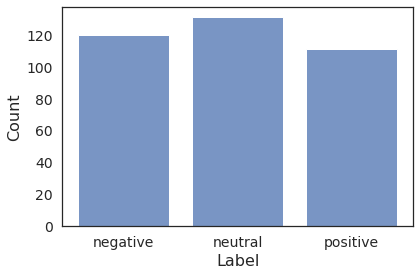

In [7]:
import matplotlib.pyplot as plt

for name, df in {"unanimous": df_unanimous, "majority": df_majority}.items():
    plt.close()
    df = df.sort_values(by="Label", ascending=True)
    df["Label"] = df["Label"].map({-1:"negative", 0:"neutral", 1:"positive"})
    hist = sns.histplot(data=df, x="Label", palette="colorblind", shrink=.8)
    #plt.title(f"Frequencies of {name} voted labels", fontsize=16)
    hist.set_xlabel("Label", fontsize=16)
    hist.set_ylabel("Count", fontsize=16)
    hist.tick_params(labelsize=14)
    plt.tight_layout()

    #plt.savefig(os.path.join(out_path, f"gerpt2_{name}_voted.png",
    #                    format='png',dpi=300)


In [8]:
from src.regard_prediction.inference import flip_gender

def add_genders(df, placeholder=""):

    for gender_prefix in ["Die Frau", "Der Mann"]:
        if placeholder != "":
            gendered = [
                txt.replace(placeholder, gender_prefix) for txt in df["Text"]
            ]
        else:
            gendered = [gender_prefix + " " + txt for txt in df["Text"]]
        gendered = flip_gender(
            gendered, (gender_prefix == "Die Frau")
        )
        new_df = pd.DataFrame(gendered)
        new_df = pd.concat([new_df, df['Label']], columns=["Text", "Label"])
    return new_df


In [9]:
df_unanimous["Label"] += 1
df_majority["Label"] += 1

In [10]:
def store_by_class(df, path):
    for i, val in enumerate(["negative", "neutral", "positive"]):
        for gender_prefix in ["FEMALE", "MALE"]:
            txt_col = "Female" if gender_prefix == "FEMALE" else "Male"
            gendered = df.loc[df['Label'] == i, txt_col]
            out = os.path.join(path, val)
            os.makedirs(out, exist_ok=True)
            with open(os.path.join(out, f"{gender_prefix}_{val}_regard.txt"), "w") as output:
                for txt in gendered:
                    output.write(txt+"\n")

In [11]:
#path = "" # specify
#store_by_class(df_unanimous, os.path.join(out_path, "unanimous"))
#store_by_class(df_majority, os.path.join(out_path, "majority"))

In [12]:
#df_unanimous.to_csv(os.path.join(out_path, "annotated_unanimous_voted.csv"))
#df_majority.to_csv(os.path.join(out_path, "annotated_majority_voted.csv"))